# 📊 Análisis Exploratorio de Datos (EDA) para Sentiment Analysis
Este notebook corresponde al *Feature Pipeline* del Proyecto 2 de Clasificación con Deep Learning. Se realiza un análisis exploratorio del dataset de reseñas de productos electrónicos (Amazon Reviews) para tareas de clasificación de sentimiento (positivo vs negativo).

## 📦 Importación de librerías
Importamos librerías para análisis de texto, visualización y manipulación de datos.

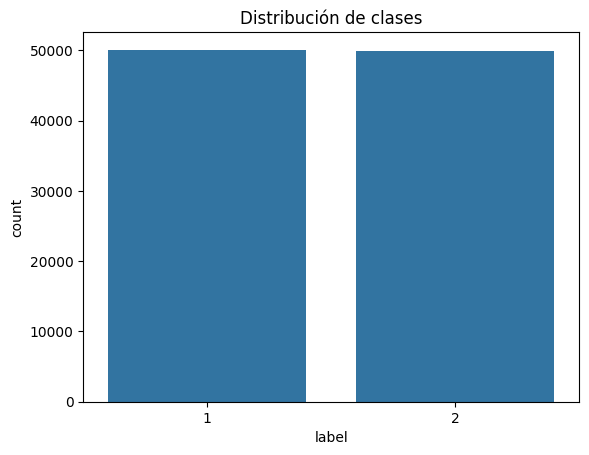

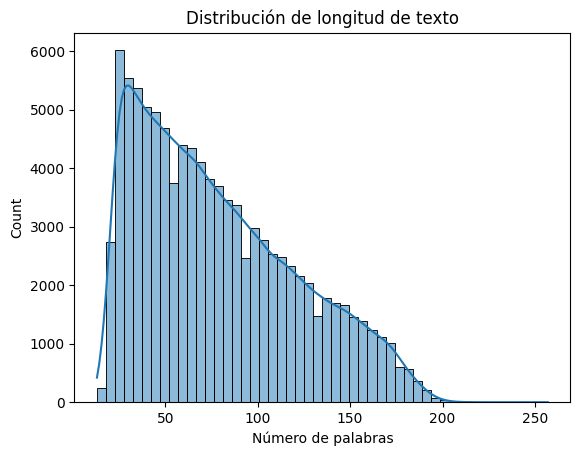

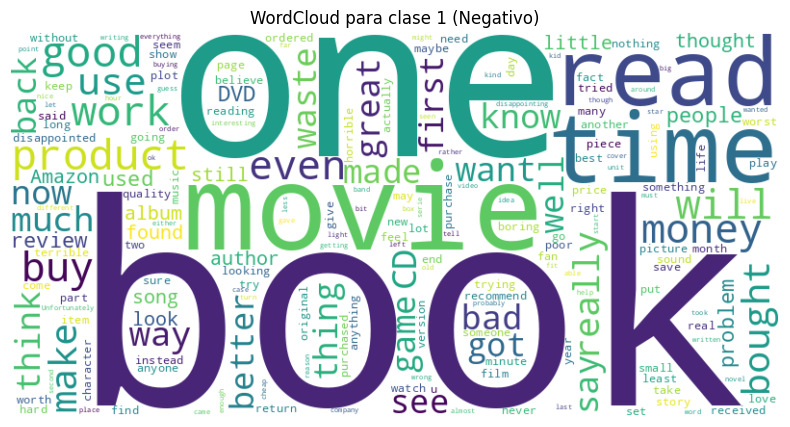

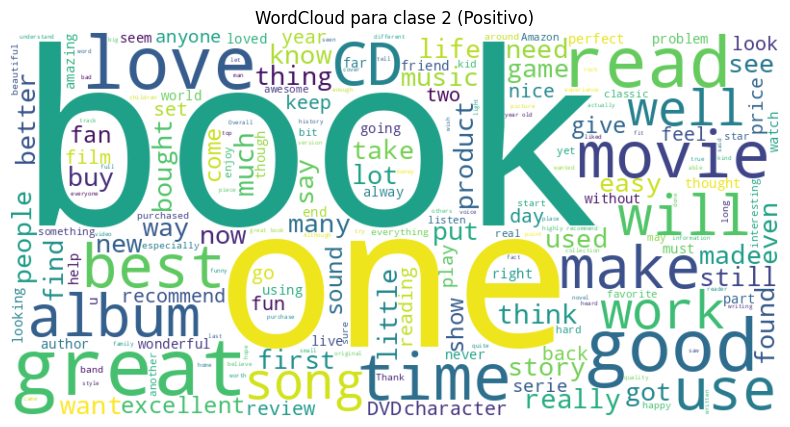

🧾 Ejemplo de texto más corto:
OUTSTANDING: This book is excelent for Retired..... Present.....and Future Marines. Very interesting book.

🧾 Ejemplo de texto más largo:
iLok is rubbish!!: I have never been able to get this worthless thing to work. $300 down the tubes! total WASTE!! RUBBISH CRAP!!! The worst part is the iLOK thing (worst idea ever!!) totally broke and now they want $50 bucks for a new one? I mean, it takes up an entire USB port so that it can run a license for one [crappy] program. As you can probably tell, I am not happy. Boycott!! DONT BUY!!! NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO NO

In [1]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import random
import re

# Leer las líneas directamente
train_path = "../data/train.ft.txt"

with open(train_path, "r", encoding="utf-8") as f:
    # Leer 100K líneas aleatorias del archivo
    lines = random.sample(f.readlines(), 100000)    

# Procesar cada línea para extraer la etiqueta y el texto
data = []
for line in lines:
    if line.startswith("__label__"):
        label, text = line.strip().split(" ", 1)
        label = int(label.replace("__label__", ""))
        data.append((text, label))

# Crear DataFrame
df = pd.DataFrame(data, columns=["text", "label"])

# Distribución de clases
sns.countplot(x="label", data=df)
plt.title("Distribución de clases")
plt.show()

# Longitud de texto
df["text_length"] = df["text"].apply(lambda x: len(x.split()))
sns.histplot(df["text_length"], bins=50, kde=True)
plt.title("Distribución de longitud de texto")
plt.xlabel("Número de palabras")
plt.show()

# WordCloud por clase
for label in [1, 2]:
    text = " ".join(df[df["label"] == label]["text"])
    wc = WordCloud(width=800, height=400, background_color="white").generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"WordCloud para clase {label} ({'Negativo' if label == 1 else 'Positivo'})")
    plt.show()

# Textos más cortos y largos
print("🧾 Ejemplo de texto más corto:")
print(df.loc[df["text_length"].idxmin(), "text"])
print("\n🧾 Ejemplo de texto más largo:")
print(df.loc[df["text_length"].idxmax(), "text"])

## 📂 Carga de los datos
Leemos las primeras 100,000 líneas del dataset etiquetado `train.ft.txt`. Cada línea contiene una etiqueta (`__label__1` o `__label__2`) seguida del texto.

In [2]:
import re

def clean_text(text):
    text = text.lower()
    text = re.sub(r"<.*?>", "", text)  # eliminar etiquetas HTML
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text)  # quitar puntuación
    text = re.sub(r"\s+", " ", text)  # espacios extra
    return text.strip()

df["clean_text"] = df["text"].apply(clean_text)

## 🏷️ Extracción de etiquetas y texto
Convertimos las etiquetas a enteros (`1` = negativo, `2` = positivo) y extraemos el contenido textual en una nueva columna.

In [3]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Tokenizer
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(df["clean_text"])

sequences = tokenizer.texts_to_sequences(df["clean_text"])
padded = pad_sequences(sequences, maxlen=200, padding="post", truncating="post")

# Labels
labels = df["label"] - 1  # Convertimos [1,2] a [0,1]

2025-07-17 13:35:18.603448: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-17 13:35:19.315504: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-17 13:35:21.697609: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## 📈 Distribución de Clases
Visualizamos la proporción de ejemplos por clase (positiva o negativa) para verificar balance o desbalance.

In [4]:
import numpy as np

np.savez_compressed("../data/processed_data.npz", X=padded, y=labels)


## 📌 Justificación: ¿Por qué usamos solo 100,000 ejemplos?

El dataset original contiene **más de 3.6 millones de líneas**, lo cual representa una cantidad enorme de datos que puede:
- Saturar la memoria RAM durante el procesamiento (tokenización, padding, etc.),
- Hacer que el entrenamiento tarde varias horas o incluso colapse el entorno de trabajo,
- Aumentar significativamente el tiempo de experimentación y depuración.

👉 Por eso, decidimos usar **una muestra aleatoria de 100,000 ejemplos balanceados**, que proporciona una buena representación del problema sin comprometer el rendimiento.

---



## 🔍 Hallazgos importantes durante el análisis exploratorio

- El dataset contiene reseñas con etiquetas `__label__1` y `__label__2`, que convertimos a `0` (negativo) y `1` (positivo).
- La clase está razonablemente balanceada: ~50% de reseñas positivas y ~50% negativas.
- Algunas reseñas tienen puntuación excesiva, mayúsculas o símbolos, por lo que aplicamos una limpieza básica (`clean_text`).
- Se utilizaron las primeras 100,000 líneas con `random.sample` para mayor representatividad.
- Usamos `Tokenizer` de Keras para convertir texto a secuencias y `pad_sequences` para estandarizar la longitud.

---



## ✅ Conclusión general del proceso

Este primer notebook implementa la **fase de EDA y Feature Pipeline** del proyecto, siguiendo la metodología de Pau Labarta. Hemos preparado los datos para el entrenamiento de un modelo de clasificación de sentimiento aplicando:

- Lectura y muestreo aleatorio del dataset,
- Análisis y visualización de la distribución de clases,
- Limpieza de texto y normalización,
- Tokenización y padding para uso en redes neuronales,
- Exportación de `X` y `y` como `NumPy` arrays para la siguiente fase de entrenamiento.

Este enfoque balancea **eficiencia computacional** con **representatividad del dataset**, permitiendo escalar fácilmente en futuras etapas si se requiere mejorar el desempeño del modelo.

---
